# Project Name - Shopper Spectrum

##### **Project Type**    - Usupervised / Clustering
##### **Contribution**    - Individual
##### **Member       - Puneeth Sai Satvik**

## Project Summary

The project mainly deals with online retail data where it contains the records of customers, invoices, products, dates, etc. The main objective is to analyze the data using exploratory data analysis to find some insights with graphs, cluster the customers based on high value, at risk and regular by computing RFM values and using KMeans clustering taking n=3 (Found optimal from the elbow curve) and generate a product heatmap based on the correlation between them by generating user-item pivot table and calculating the cosine similarity between them and plotting it.

In addition to this analysis, the clustering model which is to be exported and the algorithm to find the similarity (using cosine similarity) is used to develop a web application using StreamLit that has two pages. First is the customer segmentation module that essentially takes recency, frequency and monetary as the input and predicts which cluster (High value, At risk or Regular) the customer belongs to based on the data trained using the dataset. Second is the product recommendation module that takes the product name (Not case-sensitive) as the input and generates a list of 5 similar products based on the cosine similarity that is calculated during the heatmap plot.

The Final outputs are the python notebook **Shopper_Spectrum.ipynb** that contains the main analysis phase, model creation and testing and the StreamLit python file **Index.py** that consists of importing the model and using it to develop the application with the mentioned features.

Other Files
* online_retail.csv - Initial dataset
* Cleaned_online_retail.csv - Cleaned dataset obtained after data preprocessing
* Customer_Cluster_Model.pk - KMeans model trained using the dataset
* Scaler.pkl - Scaler used on the dataset

## GitHub Link

https://github.com/puneethsai001/ShopperSpectrum

## Dataset Collection and understanding

### Know Your Data

In [73]:
# Essential Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
# Load the dataset
retail_df = pd.read_csv('online_retail.csv')

In [40]:
# Dataset Head
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [41]:
# Row and Columns Count
retail_df.shape

(541909, 8)

In [42]:
# Dataset Info
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [43]:
# Duplicate Count
retail_df.duplicated().sum()

np.int64(5268)

In [44]:
# Missing Values/Null Values Count
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

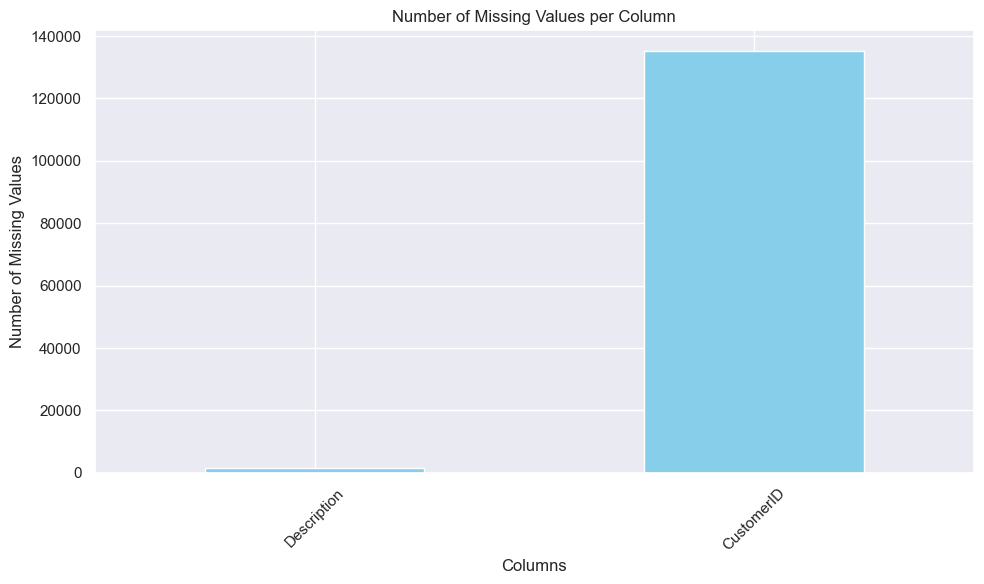

In [45]:
# Visualizing the missing values

null_counts = retail_df.isnull().sum()
null_counts = null_counts[null_counts > 0]

# Plot

plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### What did you know about your dataset?

Answer: The dataset is straightforward to understand and has 541K rows. It is mostly clean but has 135K null values of CustomerID and 1454 null values of Description that must be eliminated for easier analysis. In addition to this, it also has 5268 duplicates which also should be deleted for more refined insights.

### Understand the Variables

In [46]:
# Dataset Columns
retail_df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [47]:
# Dataset Describe
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [48]:
# Check Unique Values for each variable.
retail_df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

## Data Preprocessing

In [49]:
# Removing rows with null customerID
retail_df.dropna(subset=['CustomerID'], inplace=True)

In [50]:
# Excluding cancelled invoices
retail_df = retail_df[~retail_df['InvoiceNo'].str.startswith('C')]

In [51]:
# Remove negative or zero quantities and prices
retail_df = retail_df[(retail_df['Quantity'] > 0) & (retail_df['UnitPrice'] > 0)]

In [52]:
# Remove the duplicates
retail_df.drop_duplicates(inplace=True)

In [53]:
# Removing rows with null Description
retail_df.dropna(subset=['Description'], inplace=True)

In [54]:
# Convert InvoiceDate to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])

In [55]:
# Export cleaned dataset
retail_df.to_csv('Cleaned_online_retail.csv', sep=',')

## Exploratory Data Analysis

In [56]:
# Analyze transaction volume by country

transaction_volume_by_country = retail_df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
transaction_volume_by_country

Country
United Kingdom          16646
Germany                   457
France                    389
EIRE                      260
Belgium                    98
Netherlands                94
Spain                      90
Australia                  57
Portugal                   57
Switzerland                51
Finland                    41
Italy                      38
Norway                     36
Sweden                     36
Channel Islands            26
Poland                     19
Japan                      19
Denmark                    18
Austria                    17
Cyprus                     16
Unspecified                 8
Iceland                     7
Singapore                   7
Canada                      6
Malta                       5
Israel                      5
Greece                      5
USA                         5
Lithuania                   4
European Community          4
United Arab Emirates        3
Czech Republic              2
Bahrain                     2
Le

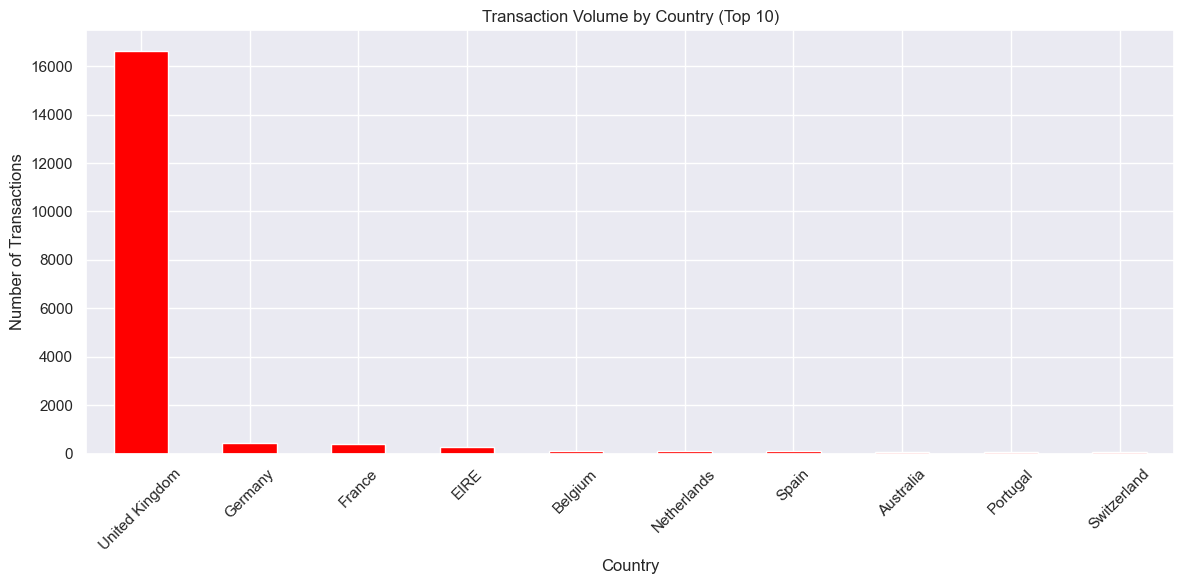

In [57]:
# Visualizing transaction volume by country (Top 10)

plt.figure(figsize=(12, 6))
transaction_volume_by_country.head(10).plot(kind='bar', color='red')
plt.title('Transaction Volume by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
# Identify top-selling products
top_selling = retail_df[['Description', 'Quantity']].sort_values(by='Quantity', ascending=False).head(5)
top_selling = top_selling.reset_index(drop=True)
top_selling

,Description,Quantity
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,74215
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800
3,SMALL POPCORN HOLDER,4300
4,EMPIRE DESIGN ROSETTE,3906


Text(0, 0.5, 'Quantity Sold')

<Figure size 1000x600 with 0 Axes>

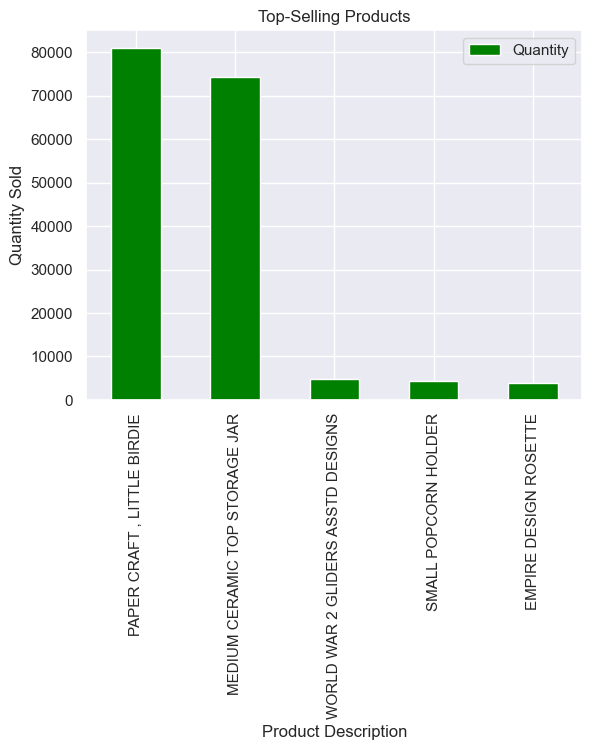

In [59]:
# Visualizing top-selling products (Top 5)

plt.figure(figsize=(10, 6))
top_selling.plot(kind='bar', x='Description', y='Quantity', color='green')
plt.title('Top-Selling Products')
plt.xlabel('Product Description')
plt.ylabel('Quantity Sold')

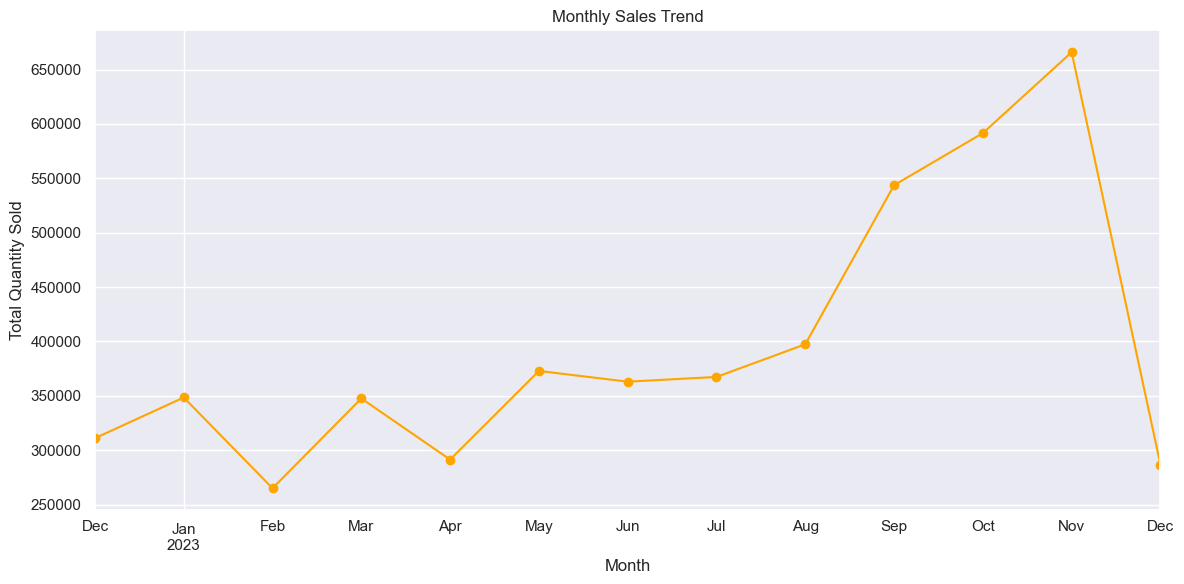

In [60]:
# Visualize purchase trends over time

retail_df['YearMonth'] = retail_df['InvoiceDate'].dt.to_period('M')

plt.figure(figsize=(12, 6))
monthly_sales = retail_df.groupby('YearMonth')['Quantity'].sum()
monthly_sales.plot(kind='line', marker='o', color='orange')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.tight_layout()
plt.show()

In [61]:
# Inspect monetary distribution per transaction and customer

# Customer monetary
customer_monetary = retail_df.groupby('CustomerID')['UnitPrice'].sum().sort_values(ascending=False)
customer_monetary

CustomerID
14096.0    33332.45
14911.0    26150.35
17841.0    19471.68
12744.0    12949.99
12748.0    11788.31
             ...   
17752.0        0.42
13366.0        0.39
12875.0        0.34
18084.0        0.29
15118.0        0.17
Name: UnitPrice, Length: 4338, dtype: float64

In [62]:
# Transaction monetary
transaction_monetary = retail_df.groupby('InvoiceNo')['UnitPrice'].sum().sort_values(ascending=False)
transaction_monetary

InvoiceNo
551697    8142.75
571751    6068.06
573080    4161.06
573077    4161.06
548813    4037.77
           ...   
569235       0.12
579725       0.12
567869       0.08
544152       0.06
560599       0.06
Name: UnitPrice, Length: 18532, dtype: float64

In [63]:
# RFM Distribution

from datetime import timedelta

# Create Monetary column
retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']

# Reference date for recency calculation
snapshot_date = retail_df['InvoiceDate'].max() + timedelta(days=1)

# RFM Calculation
rfm = retail_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

rfm = rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}).reset_index()

rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40
...,...,...,...,...
4333,18280.0,278,1,180.60
4334,18281.0,181,1,80.82
4335,18282.0,8,2,178.05
4336,18283.0,4,16,2045.53


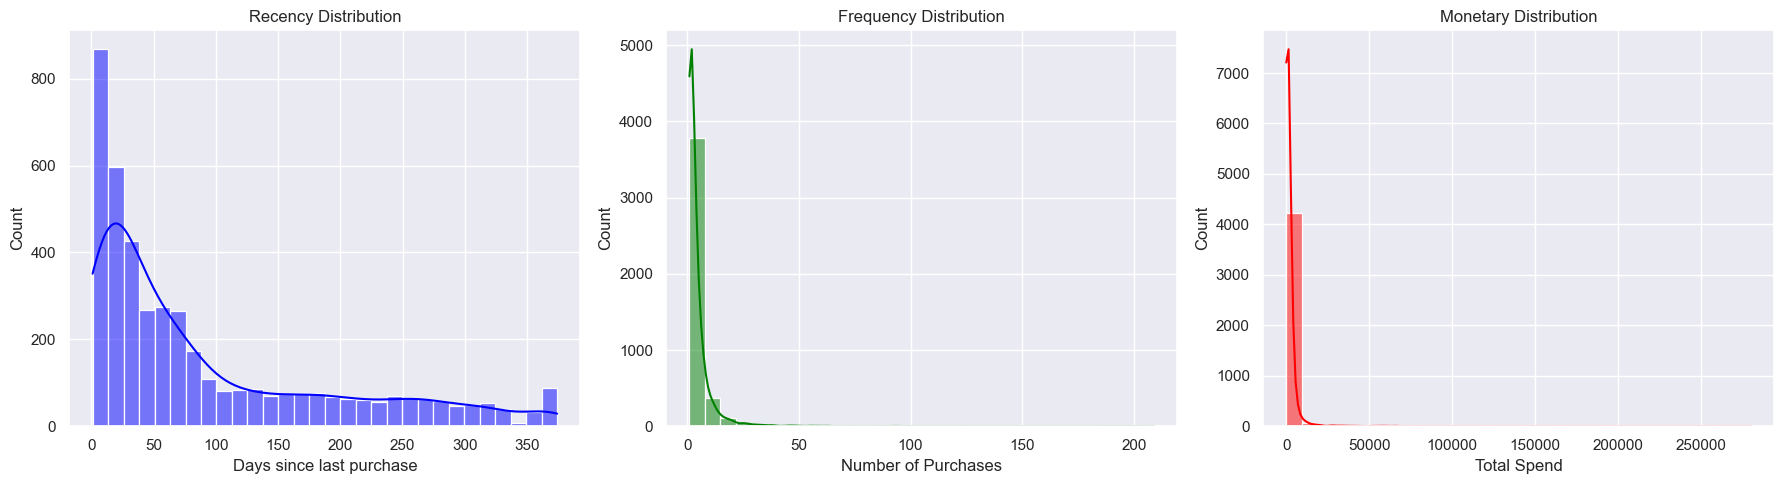

In [64]:
# Visualize RFM distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'], kde=True, ax=axes[0], bins=30, color='blue')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days since last purchase')

sns.histplot(rfm['Frequency'], kde=True, ax=axes[1], bins=30, color='green')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of Purchases')

sns.histplot(rfm['Monetary'], kde=True, ax=axes[2], bins=30, color='red')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total Spend')

plt.tight_layout()
plt.show()

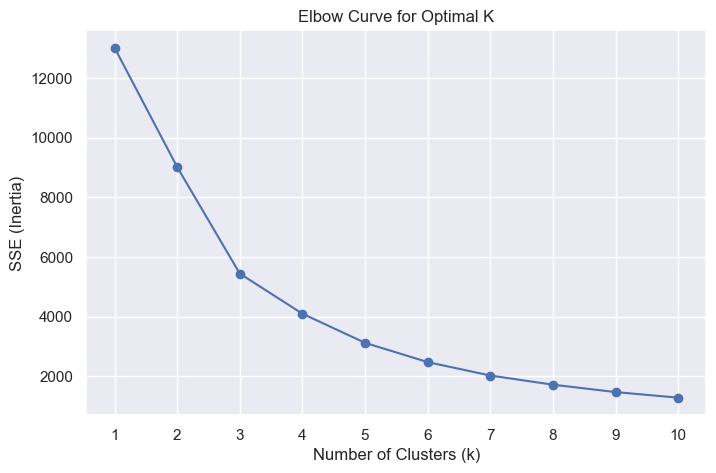

In [65]:
# Elbow curve for cluster selection

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale the RFM values
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)

# Compute distortions for K=1 to 10
sse = []  # Sum of squared distances
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)  # Inertia = SSE

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Curve for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.grid(True)
plt.xticks(k_range)
plt.show()

In [66]:
# Customer cluster profiles

# Apply kmeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

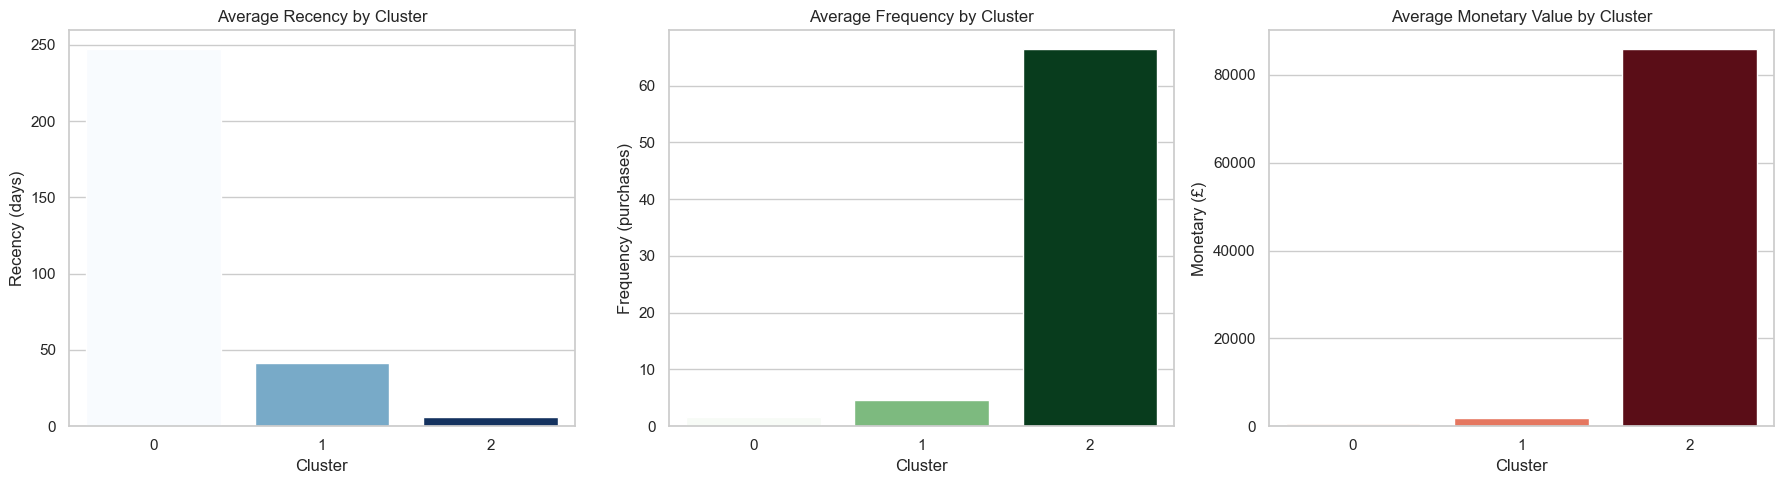

In [67]:
# Visualize based on KMeans Cluster

cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'  # optional: size of each cluster
}).rename(columns={'CustomerID': 'Num_Customers'}).reset_index()


sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Recency
sns.barplot(data=cluster_profile, x='Cluster', y='Recency', ax=axes[0], hue='Cluster', palette='Blues', legend=False)
axes[0].set_title('Average Recency by Cluster')
axes[0].set_ylabel('Recency (days)')
axes[0].set_xlabel('Cluster')

# Plot Frequency
sns.barplot(data=cluster_profile, x='Cluster', y='Frequency', ax=axes[1], hue='Cluster', palette='Greens', legend=False)
axes[1].set_title('Average Frequency by Cluster')
axes[1].set_ylabel('Frequency (purchases)')
axes[1].set_xlabel('Cluster')

# Plot Monetary
sns.barplot(data=cluster_profile, x='Cluster', y='Monetary', ax=axes[2], hue='Cluster', palette='Reds', legend=False)
axes[2].set_title('Average Monetary Value by Cluster')
axes[2].set_ylabel('Monetary (£)')
axes[2].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

In [68]:
# Adding segment Label based on the graph

segment_map = {
    0: 'At-Risk',
    1: 'Regular',
    2: 'High Value'
}

rfm['Segment'] = rfm['Cluster'].map(segment_map)

rfm

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,326,1,77183.60,0,At-Risk
1,12347.0,2,7,4310.00,1,Regular
2,12348.0,75,4,1797.24,1,Regular
3,12349.0,19,1,1757.55,1,Regular
4,12350.0,310,1,334.40,0,At-Risk
...,...,...,...,...,...,...
4333,18280.0,278,1,180.60,0,At-Risk
4334,18281.0,181,1,80.82,0,At-Risk
4335,18282.0,8,2,178.05,1,Regular
4336,18283.0,4,16,2045.53,1,Regular


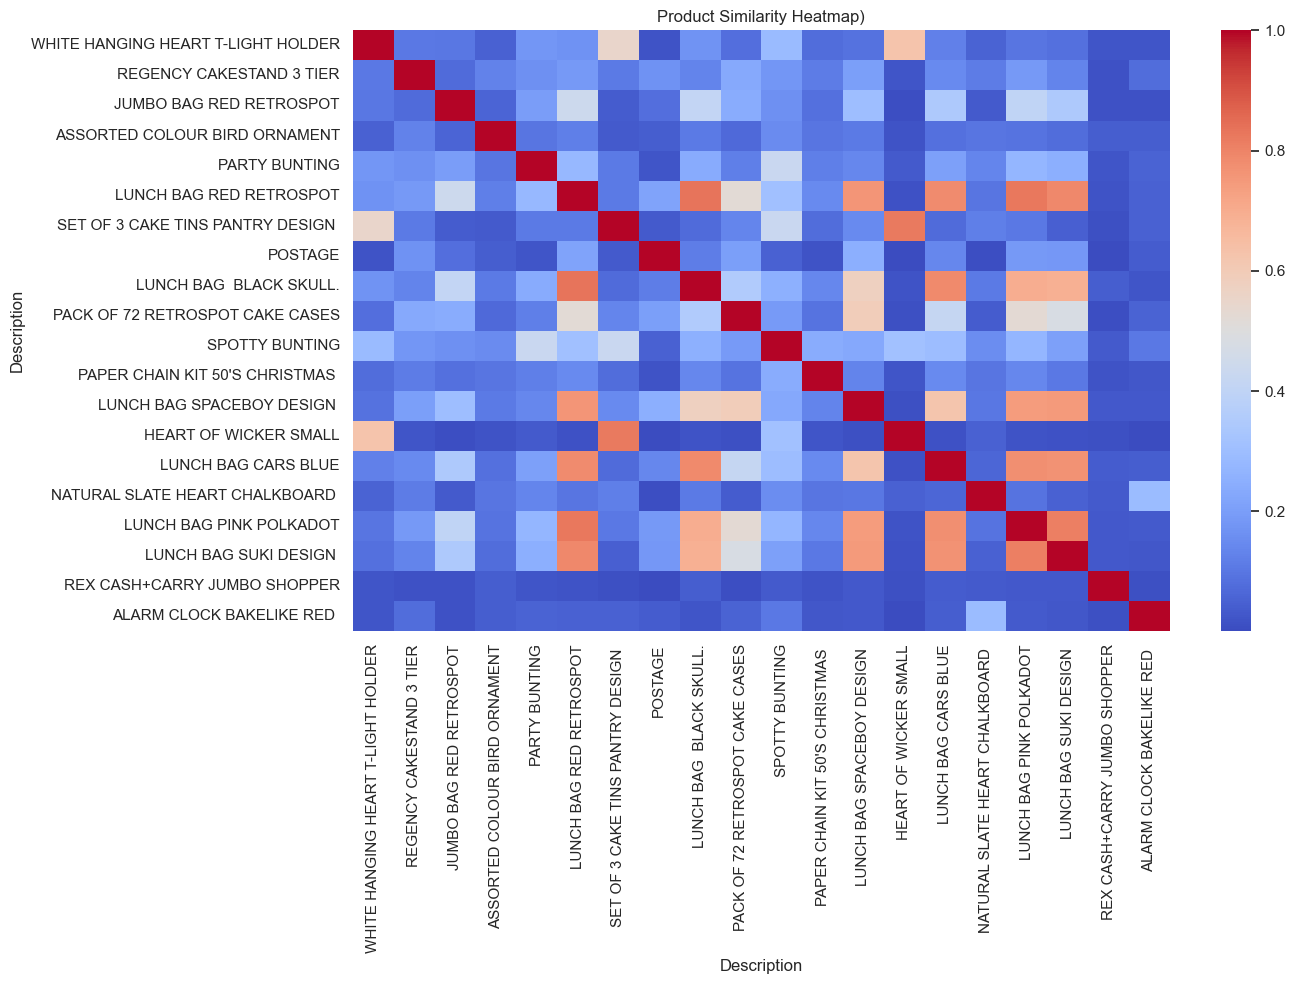

In [69]:
from sklearn.metrics.pairwise import cosine_similarity

# Create User-Item Matrix
user_item_matrix = retail_df.pivot_table(index='CustomerID',
                                         columns='Description',
                                         values='Quantity',
                                         aggfunc='sum',
                                         fill_value=0)

# Compute Cosine Similarity between Products
item_similarity = cosine_similarity(user_item_matrix.T)

# Convert to DataFrame for heatmap
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=user_item_matrix.columns,
                                  columns=user_item_matrix.columns)

top_items = retail_df['Description'].value_counts().head(20).index
item_similarity_sample = item_similarity_df.loc[top_items, top_items]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(item_similarity_sample, cmap='coolwarm', annot=False)
plt.title('Product Similarity Heatmap)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [70]:
# Function to recommend similar products

def recommend_similar_products(item_name, top_n=5):

    if item_name not in item_similarity_df.index:
        print(f"Product '{item_name}' not found in dataset.")
        return []

    # Get similarity scores
    sim_scores = item_similarity_df[item_name].sort_values(ascending=False)

    similar_products = pd.DataFrame(sim_scores.head(top_n))
    return similar_products

# Testing similar products
input_product = 'WHITE HANGING HEART T-LIGHT HOLDER'
recommendations = recommend_similar_products(input_product)

recommendations

,WHITE HANGING HEART T-LIGHT HOLDER
Description,
WHITE HANGING HEART T-LIGHT HOLDER,1.000000
GIN + TONIC DIET METAL SIGN,0.750192
RED HANGING HEART T-LIGHT HOLDER,0.658714
WASHROOM METAL SIGN,0.643520
LAUNDRY 15C METAL SIGN,0.642200


## Export Model

In [71]:
# Exporting using pickle
import pickle

# Save Kmeans model
with open('Customer_Cluster_Model.pkl', 'wb') as files:
    pickle.dump(kmeans, files)

# Save scaler
with open('Scaler.pkl', 'wb') as files:
    pickle.dump(scaler, files)

In [72]:
# Testing the exported model

# Load KMeans model
with open('Customer_Cluster_Model.pkl', 'rb') as f:
    loaded_kmeans = pickle.load(f)

# Load Scaler
with open('Scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Function to classify using loaded model
def classify_customer(r, f, m):
    new_rfm = pd.DataFrame([[r, f, m]], columns=['Recency', 'Frequency', 'Monetary'])
    new_rfm_scaled = loaded_scaler.transform(new_rfm)
    cluster = loaded_kmeans.predict(new_rfm_scaled)[0]
    segment = segment_map.get(cluster, "Unknown")
    return cluster, segment

test_cases = [
    {"r": 326, "f": 1, "m": 7783},
    {"r": 30, "f": 4, "m": 800},
    {"r": 24, "f": 21, "m": 124914}
]

for i, test in enumerate(test_cases, 1):
    c, s = classify_customer(test['r'], test['f'], test['m'])
    print(f"\nTest Case {i}: R={test['r']}, F={test['f']}, M={test['m']}")
    print(f"Predicted Cluster: {c}")
    print(f"Customer Segment: {s}")



Test Case 1: R=326, F=1, M=7783
Predicted Cluster: 0
Customer Segment: At-Risk

Test Case 2: R=30, F=4, M=800
Predicted Cluster: 1
Customer Segment: Regular

Test Case 3: R=24, F=21, M=124914
Predicted Cluster: 2
Customer Segment: High Value
